# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tkinter import Tk, filedialog, simpledialog
from tkinter.ttk import Combobox
import itertools
import pandas as pd
from tkinter import Tk, filedialog, simpledialog
from tkinter.ttk import Combobox, Button, Label
import sys  # Import sys module for exit function


# EXTRACT DATA AND PERFORM TEST


Model Formula
pain ~ C(gender) + C(drug) + C(gender):C(drug)

DataFrame shape before filtering:
(1001, 12)

DataFrame shape after filtering:
(48, 12)

ANOVA Results:
                       sum_sq    df          F        PR(>F)
C(gender)           79.457693   1.0  37.799464  2.431353e-07
C(drug)            194.839755   2.0  46.344401  2.356535e-11
C(gender):C(drug)   49.579774   2.0  11.792998  8.613934e-05
Residual            88.287577  42.0        NaN           NaN

Model Summary
                            OLS Regression Results                            
Dep. Variable:                   pain   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     30.81
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           4.96e-13
Time:                        15:59:06   Log-Likelihood:                -82.735
No. Observations:                  48  

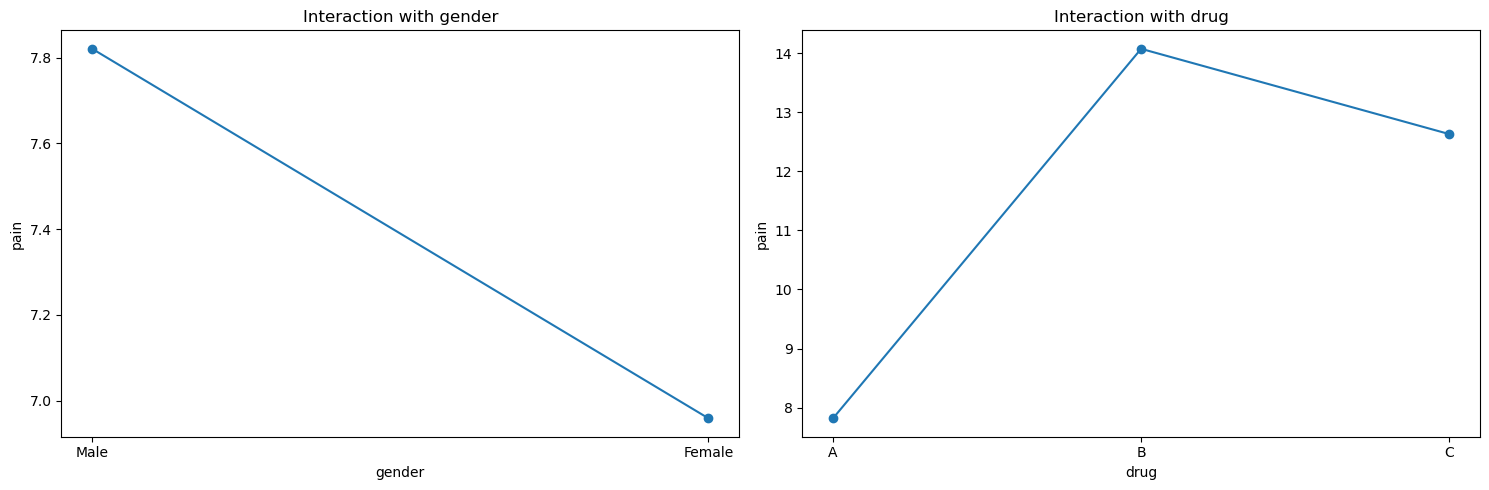

<Figure size 800x600 with 0 Axes>

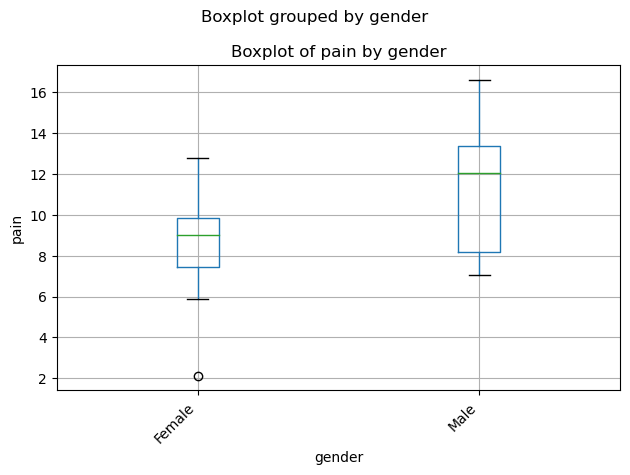

<Figure size 800x600 with 0 Axes>

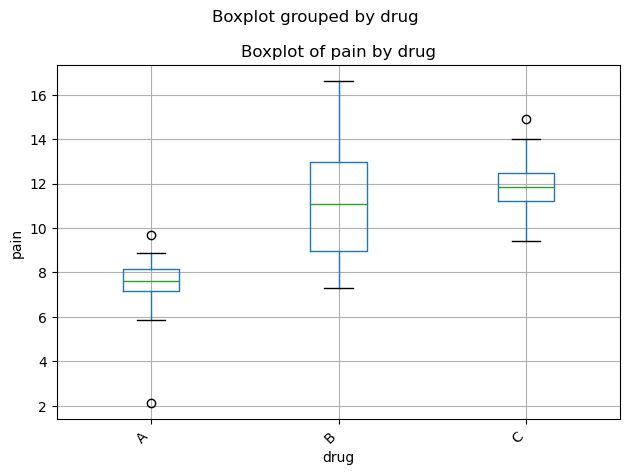

In [2]:


# Global variables
df = None
factors = []
response = None
window = None
analysis_performed = False

# Read Excel file and perform Two-Way ANOVA
def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        global df
        df = pd.read_excel(file_path)  # Read Excel file into a DataFrame
        df = df.dropna(axis=1, how='all')  # Drop entirely blank columns
        return df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None

def perform_n_way_anova(df, factors, response):
    """Performs n-way ANOVA and displays the results."""
    try:
        # Construct formula for n-way ANOVA with main effects and interactions
        main_effects = [f"C({factor})" for factor in factors]
        interactions = []

        # Generate all possible interaction terms
        for r in range(2, len(factors) + 1):  # Consider interactions of size 2 to n
            for combo in itertools.combinations(factors, r):
                interactions.append(":".join([f"C({factor})" for factor in combo]))

        # Combine main effects and interactions in the formula
        formula = f"{response} ~ {' + '.join(main_effects + interactions)}"

        # Print Model Formula
        print("\nModel Formula")
        print(formula)

        # Print DataFrame shape before filtering
        print("\nDataFrame shape before filtering:")
        print(df.shape)

        # Filter DataFrame based on factors
        for factor in factors:
            df = df[df[factor].notna()]

        # Print DataFrame shape after filtering
        print("\nDataFrame shape after filtering:")
        print(df.shape)
        
        # Perform n-way ANOVA
        model = smf.ols(formula, data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Print ANOVA Table
        print("\nANOVA Results:")
        print(anova_table)

        # Print Model Summary
        print("\nModel Summary")
        print(model.summary())

        # Plot interaction effects for n-way ANOVA
        if len(factors) >= 2:  # Require at least two factors for interaction plots
            plot_interaction_nway(df, model, factors, response)
        else:
            print("Interaction plot requires at least two factors.")

    except Exception as e:
        print(f"Error performing n-way ANOVA: {e}")

def plot_box_plots(df, factors, response):
    """Plots box plots for each factor level of the response variable."""
    if df is None:
        print("DataFrame is empty.")
        return
    
    # Ensure factors are strings
    factors = [str(factor) for factor in factors]
    
    # Plot box plots for each factor level
    for factor in factors:
        plt.figure(figsize=(8, 6))
        df.boxplot(column=response, by=factor)
        plt.title(f'Boxplot of {response} by {factor}')
        plt.xlabel(factor)
        plt.ylabel(response)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


def plot_interaction_nway(df, model, factors, response):
    """Plots the interaction effects for n-way ANOVA."""
    try:
        # Generate the interaction plot for n factors
        fig, axes = plt.subplots(nrows=1, ncols=len(factors), figsize=(15, 5))
        for i, factor in enumerate(factors):
            # Extract factor levels
            factor_levels = df[factor].unique()

            # Create dummy DataFrame with all combinations of factor levels
            dummy_data = pd.DataFrame(list(itertools.product(*[factor_levels])), columns=[factor])

            # Add other factors to dummy data for interaction terms
            for other_factor in factors:
                if other_factor != factor:
                    dummy_data[other_factor] = df[other_factor].iloc[0]  # Choose any value from original data

            # Predict response variable for each combination
            predictions = model.predict(exog=dummy_data)

            # Plot interaction effect
            axes[i].plot(dummy_data[factor], predictions, marker='o')
            axes[i].set_title(f"Interaction with {factor}")
            axes[i].set_xlabel(factor)
            axes[i].set_ylabel(response)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting interaction effects: {e}")


def analyze_data():
    """Callback function to analyze data."""
    # Get user-selected values from dropdowns
    selected_factors = [factor.get() for factor in factors]
    selected_response = response.get()

    # Perform two-way ANOVA
    perform_n_way_anova(df, selected_factors, selected_response)

    # Plot box plots for factor combinations
    plot_box_plots(df, selected_factors, selected_response)

    # Close the Tkinter window
    window.destroy()


def get_factor_selection():
    """Ask the user for the number of factors."""
    global num_factors
    num_factors = simpledialog.askinteger("Number of Factors", "Enter the number of factors:")

    if num_factors:
        show_factor_selection_popup()

def show_factor_selection_popup():
    """Show the popup for factor and response variable selection."""
    global window, factors, response
    window = Tk()
    window.title("Factor and Response Selection")

    # Create labels and dropdowns for factor selection
    factor_labels = []
    factors = []
    for i in range(num_factors):
        factor_label = Label(window, text=f"Select Factor {i + 1}:")
        factor_label.grid(row=i, column=0)
        
        factor = Combobox(window, values=df.columns.tolist())
        factor.grid(row=i, column=1)
        factors.append(factor)

    # Label and dropdown for response variable selection
    response_label = Label(window, text="Select Response Variable:")
    response_label.grid(row=num_factors, column=0)
    response = Combobox(window, values=df.columns.tolist())
    response.grid(row=num_factors, column=1)

    # Add analyze button
    analyze_button = Button(window, text="Analyze", command=analyze_data)
    analyze_button.grid(row=num_factors + 1, columnspan=2)

    # Start GUI event loop
    window.mainloop()

def main():
    global df, num_factors, analysis_performed

    # Open a file dialog to select Excel file
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
    if not file_path:
        print("No file selected.")
        return

    # Read Excel file into DataFrame
    df = read_excel_file(file_path)
    if df is None:
        print("Error reading Excel file.")
        return

    # Ask the user for the number of factors
    get_factor_selection()

    # Check if analysis has been performed
    if analysis_performed:
        print("Analysis completed.")

        # Get user-selected values from dropdowns
        selected_factors = [factor.get() for factor in factors]
        selected_response = response.get()

        # Perform n-way ANOVA
        perform_n_way_anova(df, selected_factors, selected_response)

        # Plot box plots for factor combinations
        plot_box_plots(df, selected_factors, selected_response)

        print("Exiting...")
    else:
        print("Analysis not performed. Exiting...")


if __name__ == "__main__":
    main()

